# Depth Estimation & Point Cloud Reconstruction

The tutorial demonstrates how to use ZenSVI to estimatie depth information from street view imagery, and further integrate the depth and color information to reconstruct point cloud.  
Contributer: [Zicheng Fan](https://github.com/fzc961020)

## Import module

In [ ]:
#pip install --upgrade zensvi
#pip install img2vec_pytorch
#pip install faiss-cpu

Choice 1: Import ZenSVI and PointCloudProcessor function from local

In [ ]:
import sys
import os

# Get the current notebook's directory (docs/examples) dynamically
notebook_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()

# Construct the path to the src folder relative to the notebook location
src_path = os.path.normpath(os.path.join(notebook_dir, '../../src'))

# Add the src folder to sys.path
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Now import your package
from zensvi.transform import PointCloudProcessor
from zensvi.cv import DepthEstimator


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Choice 2: Import function directly from zensvi 

In [ ]:
# import function directly from zensvi 
from zensvi.transform import PointCloudProcessor
from zensvi.cv import DepthEstimator

## Download the test dataset

In [ ]:
from huggingface_hub import HfApi, hf_hub_download


def download_folder(repo_id, repo_type, folder_path, local_dir):
    """
    Download an entire folder from a huggingface dataset repository.
    repo_id : string
        The ID of the repository (e.g., 'username/repo_name').
    repo_type : string
        Type of the repo, dataset or model.
    folder_path : string
        The path to the folder within the repository.
    local_dir : string
        Local folder to download the data. This mimics git behaviour
    """
    api = HfApi()
    # list all files in the repo, keep the ones within folder_path
    all_files = api.list_repo_files(repo_id, repo_type=repo_type)
    files_list = [f for f in all_files if f.startswith(folder_path)]

    # download each of those files
    for file_path in files_list:
        hf_hub_download(repo_id=repo_id, repo_type=repo_type,
                        filename=file_path, local_dir=local_dir)


# Download test dataset for the example
repo_id = "NUS-UAL/zensvi_test_data" # the test dataset repo
repo_type = "dataset" # required by the API when the repo is a dataset
folder_path = "input/depth_point_cloud/" # the specific data
local_dir = "zensvi_example_data/" # the local folder in your computer where it will be downloaded

# By default, huggingface download them to the .cache/huggingface folder
download_folder(repo_id, repo_type, folder_path, local_dir)


## Depth Estimation

There are two different methods to conduct depth estimation in ZenSVI.   
- [DPT model](https://huggingface.co/Intel/dpt-large) from Hugging Face is used for relative depth estimation. 
- [ZoeDepth model](https://github.com/LiheYoung/Depth-Anything/tree/1e1c8d373ae6383ef6490a5c2eb5ef29fd085993/metric_depth) is used for absolute(metric) depth estimation.

In [ ]:
from zensvi.cv import DepthEstimator

depth_estimator = DepthEstimator(
    device="cpu",  # device to use (either "cpu" or "gpu")
    task="relative" # task to perform (either "relative" or "absolute")
)

dir_input = "zensvi_example_data/input/depth_point_cloud/images/color"
dir_image_output = "zensvi_example_data/input/depth_point_cloud/images/depth" # estimated depth map
depth_estimator.estimate_depth(
    dir_input,
    dir_image_output
)

Using cpu


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Estimating depth: 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/it]


## Point Cloud Reconstruction

### Part 1: Define the PointCloudProcessor

In [ ]:
# Assuming the class PointCloudProcessor is defined as in the previous block or imported successfully
# Initialize the processor with paths to your image (color and depth) folders
processor = PointCloudProcessor(
    image_folder='zensvi_example_data/input/depth_point_cloud/images/color',
    depth_folder='zensvi_example_data/input/depth_point_cloud/images/depth'
)


We can visualize a color image and corresponding depth image from the two folders.

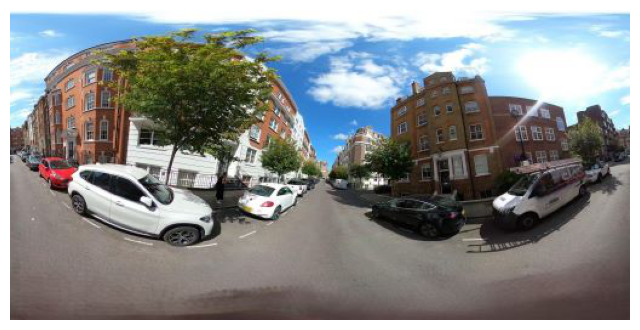

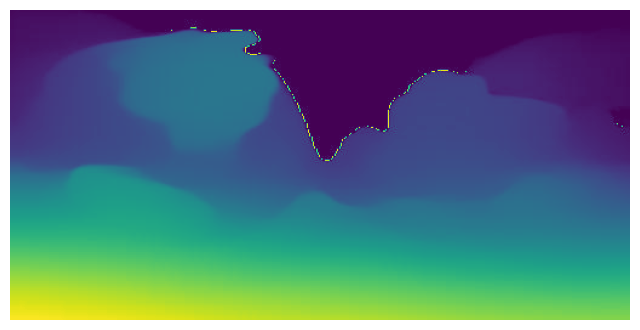

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
color_path = 'zensvi_example_data/input/depth_point_cloud/images/color/VSsVjWlr4orKerabFRy-dQ.jpg'
depth_path = 'zensvi_example_data/input/depth_point_cloud/images/depth/VSsVjWlr4orKerabFRy-dQ.jpg'


image = Image.open(color_path)
# Display the image using matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

image = Image.open(depth_path)
# Display the image using matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

### Part 2: Input csv file, indicating the images to process and other metadata

An example dataframe is shown as below.  
The image id is the only necessary attributes for indexing color and depth image when generating single point cloud.
Besides the image id, possible metadata includes: image angle ('heading'), and the real-world coordinates of image ('x_proj','y_proj'), depending on the availability. They are useful in processing multiple images, and aligning point clouds generated.


In [ ]:
# input the images
import pandas as pd
data = pd.read_csv('zensvi_example_data/input/depth_point_cloud/meta_data.csv')
data

,Unnamed: 0,year,month,lat,lon,id,heading,geometry,y_proj,x_proj
0,0,2018,8,40.773640,-73.954823,Y2y7An1aRCeA5Y4nW7ITrg,3.627108,POINT (-8232613.214232705 4979010.676803163),-8232613.214,4979010.677
1,1,2019,5,40.775753,-73.956686,VSsVjWlr4orKerabFRy-dQ,5.209303,POINT (-8232820.629621736 4979321.30902424),-8232820.630,4979321.309


We can load images as dictionary of array according to the dataframe

In [ ]:
# load all the images based on the datafrome
images = processor._load_images(data)
images

{'Y2y7An1aRCeA5Y4nW7ITrg': {'depth': array([[  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         ...,
         [243, 243, 243, ..., 240, 240, 240],
         [247, 247, 247, ..., 241, 241, 241],
         [250, 250, 250, ..., 242, 242, 242]], dtype=uint8),
  'color': array([[[132, 171, 230],
          [132, 171, 230],
          [132, 171, 230],
          ...,
          [130, 173, 226],
          [130, 173, 226],
          [130, 173, 226]],
  
         [[132, 171, 230],
          [132, 171, 230],
          [132, 171, 230],
          ...,
          [130, 173, 226],
          [130, 173, 226],
          [130, 173, 226]],
  
         [[132, 171, 230],
          [132, 171, 230],
          [132, 171, 230],
          ...,
          [130, 173, 228],
          [130, 173, 228],
          [130, 173, 228]],
  
         ...,
  
         [[103, 107, 118],
          [106, 110, 121],
          [111, 115, 126],
          

### Part 3: Generate point cloud based on single image

With the images in array, we can first generate a point cloud based on image with id 'Y2y7An1aRCeA5Y4nW7ITrg'

In [ ]:
# Generate point clouds from specific image in the dataframe
image_id = 'Y2y7An1aRCeA5Y4nW7ITrg'

depth_img = images[image_id]["depth"]
color_img = images[image_id]["color"]

pcd = processor.convert_to_point_cloud(depth_img, color_img, depth_max = 255)
pcd

PointCloud with 131072 points.

### Part 4: Process multiple images, and crop and transform the point cloud generated

We can also process multiple images with loop and apply some point cloud processing steps.

In [ ]:
# Generate point clouds from all the images in the dataframe
point_clouds = processor.process_multiple_images(data)

The processing steps include:
   - scale the point clouds to a real-world coordinates;  
   - align the point clouds according to the 'heading' information stored with SVI;
   - crop the point clouds based on a self-defined 3D bounding box (to remove unnecessary part)
    
The part will be improved with more functions and more explict control.

In [ ]:
# Optionally, transform the point clouds
transformed_clouds = []
for i, pcd in enumerate(point_clouds):
    origin_x = data.at[i, 'x_proj'] / processor.output_coordinate_scale
    origin_y = data.at[i, 'y_proj'] / processor.output_coordinate_scale
    angle = data.at[i, 'heading']
    box_extent = [3, 3, 3]  # Example box dimensions
    box_center = [origin_x, origin_y, 1]  # Example box center
    transformed_pcd = processor.transform_point_cloud(pcd, origin_x, origin_y, angle, box_extent, box_center) # crop and transform the point clouds with the parameters
    transformed_clouds.append(transformed_pcd)


In [ ]:
transformed_clouds

[PointCloud with 80361 points., PointCloud with 89626 points.]

### Part 5: Visualization

We can visualize the point clouds generated in 3d, plotly library.

In [ ]:
# Visualize the first transformed point cloud (for demonstration)
processor.visualize_point_cloud(transformed_clouds[0])

![Point_Cloud_generated](https://raw.githubusercontent.com/fzc961020/2023-Spring-ISM-Repo/cd91798c132db1bca998a297755116dbd08203f2/point_cloud_output_example.png)


### Part 6: Save point cloud in different formats

The generated point clouds can be saved to local in different formats.

In [ ]:
point_clouds = processor.process_multiple_images(data, output_dir='output_data/point_clouds', save_format="pcd")

In [ ]:
point_clouds = processor.process_multiple_images(data, output_dir='output_data/point_clouds', save_format="ply")

In [ ]:
point_clouds = processor.process_multiple_images(data, output_dir='output_data/point_clouds', save_format='npz')

In [ ]:
point_clouds = processor.process_multiple_images(data, output_dir='output_data/point_clouds', save_format='csv')